Import modules and configure the notebook.

In [2]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import scipy
# from scipy import signal
# from scipy import linalg


# This is my own script (it is an interface to the pybullet simulator)
import ae353_cmg

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_cmg)

from sympy.physics import mechanics
mechanics.init_vprinting()

## Defining Symbolic Expressions

In [3]:
#Symbols
q_1, q_2, v_1, v_2 , tau = sym.symbols('q_1, q_2, v_1, v_2, tau')

J1z = 0.5
J2x = J2z = 0.001
J3x = J3y = J3z = 0.01
m = 1.0
r = 2.0
g = 9.81
vr = 1000

a1 = -1*J3y + 2*J3z
a2 = 2*J3y
a3 = -2*g*m*r
a4 = 2*J1z + 2*J2z + 2*m*r**2
a5 = 2*J3z
a6 = (J3y - J3z) / (2* (J2x + J3x))
a7 = (-1 * J3y / (J2x + J3x))
a8 = 1 / (J2x + J3x)

#ODEs
vd1 = ((a1 * sym.sin(2*q_2) * v_1 * v_2) + (a2 * sym.cos(q_2) * v_2 * vr) + (a3 * sym.sin(q_1)))/(a4 + a5*(sym.cos(q_2))**2)
vd2 = (a6 * sym.sin(2*q_2) * (v_1**2)) + (a7 * sym.cos(q_2) * v_1 * vr) + (a8 * tau)

print(vd1)
print(vd2)


(0.01*v_1*v_2*sin(2*q_2) + 20.0*v_2*cos(q_2) - 39.24*sin(q_1))/(0.02*cos(q_2)**2 + 9.002)
90.9090909090909*tau - 909.090909090909*v_1*cos(q_2)


In [4]:
f = sym.Matrix([[v_1], [v_2], [vd1], [vd2]])
f = sym.nsimplify(f, rational=True)
f

⎡                      v₁                      ⎤
⎢                                              ⎥
⎢                      v₂                      ⎥
⎢                                              ⎥
⎢v₁⋅v₂⋅sin(2⋅q₂)                   981⋅sin(q₁) ⎥
⎢─────────────── + 20⋅v₂⋅cos(q₂) - ─────────── ⎥
⎢      100                              25     ⎥
⎢───────────────────────────────────────────── ⎥
⎢                  2                           ⎥
⎢               cos (q₂)   4501                ⎥
⎢               ──────── + ────                ⎥
⎢                  50      500                 ⎥
⎢                                              ⎥
⎢909090909090909⋅τ   909090909090909⋅v₁⋅cos(q₂)⎥
⎢───────────────── - ──────────────────────────⎥
⎣  10000000000000          1000000000000       ⎦

## Equilibrium 

In [5]:
#Desired Platform Angle in rads
q_1e = 0

#Equilibrium Values
q_2e = 0
q_1de = 0
q_2de = 0
taue = 0

f_num = sym.lambdify([q_1, q_2, v_1, v_2, tau], f)
fe = f_num(q_1e, q_2e, q_1de, q_2de, taue)
fe = fe.round(0, None)
fe

array([[0.],
       [0.],
       [0.],
       [0.]])

## Linearization

In [6]:
A_num = sym.lambdify((q_1, q_2, v_1, v_2, tau), f.jacobian([q_1, q_2, v_1, v_2]))
A = A_num(q_1e, q_2e, q_1de, q_2de, taue).astype(np.float64)

B_num = sym.lambdify((q_1, q_2, v_1, v_2, tau), f.jacobian([tau]))
B = B_num(q_1e, q_2e, q_1de, q_2de, taue).astype(np.float64)

print("A=", A)
print("B=", B)




A= [[   0.            0.            1.            0.        ]
 [   0.            0.            0.            1.        ]
 [  -4.34936821    0.            0.            2.21680337]
 [   0.            0.         -909.09090909    0.        ]]
B= [[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [90.90909091]]


In [7]:
n = 1000
for i in range(n):
    K = np.array([[np.random.uniform(0, 10), np.random.uniform(0, 5), np.random.uniform(0, 5), np.random.uniform(0,5)]])
    F = A - B@K
    e = np.linalg.eigvals(F)
    if (e.real<0).all() == True and (e.imag ==0).all() == True:
        print(K)
        print(e)
        break

[[6.65149088 0.22244181 1.02314161 1.43565604]]
[-1.10309732e+02 -1.93112291e+01 -8.44323412e-01 -4.89009536e-02]


K's that work well\\
K= [[2.78652975 0.51999503 3.72617691 3.52691023]] \\

K= [[7.57908532 1.83254784 1.25558431 4.9210056 ]]\\

In [8]:
#K= [[7.57908532, 1.83254784, 1.25558431, 4.9210056 ]]
K = np.array([[7.57908532, 1.83254784, 1.25558431,4.9210056 ]])

In [9]:
class Controller:
    def __init__(self, K, q_1e, q_2e, q_1de, q_2de, taue):
        self.K = K
        self.q_1e = q_1e
        self.q_2e = q_2e
        self.q_1de = q_1de
        self.q_2de = q_2de
        self.taue = taue
        
    def reset(self):
        pass
    def run(self, t, q_1, q_2, v_1, v_2, vr):
        #State
        x = np.array([[q_1 - self.q_1e],
                     [q_2 - self.q_2e],
                     [v_1 - self.q_1de],
                     [v_2 - self.q_2de],
                     ])
        #Input
        u = -self.K@x
        #print(u)
        gimbal_torque = u[0,0] + self.taue
        return gimbal_torque
        

## Simulation

In [10]:
simulator = ae353_cmg.Simulator(
    display=False,
    damping=0.,
    load_mass=1.,
    roll=(np.pi / 2),
)

Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to the gimbal. Modify the `run` function to make the controller behave differently.

Create an instance of the controller.

In [11]:
controller = Controller( K, q_1e, q_2e, q_1de, q_2de, taue)

Reset the simulator with given initial conditions. A low-level controller (separate from yours) will try to ensure that the rotor velocity remains constant.

In [12]:
simulator.reset(
    platform_angle= np.pi/5,
    platform_velocity=1.4,
    gimbal_angle=np.pi/7.,
    gimbal_velocity=-10.,
    rotor_velocity=1000.,
)

Reset the controller.

In [13]:
controller.reset()

Choose a camera view (could be `simulator.camera_topview()` or `simulator.camera_sideview()`).

In [14]:
simulator.camera_sideview()

Run the simulator.

In [15]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=5.,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
)

Get, show, and save a snapshot of the simulation after the last time step.

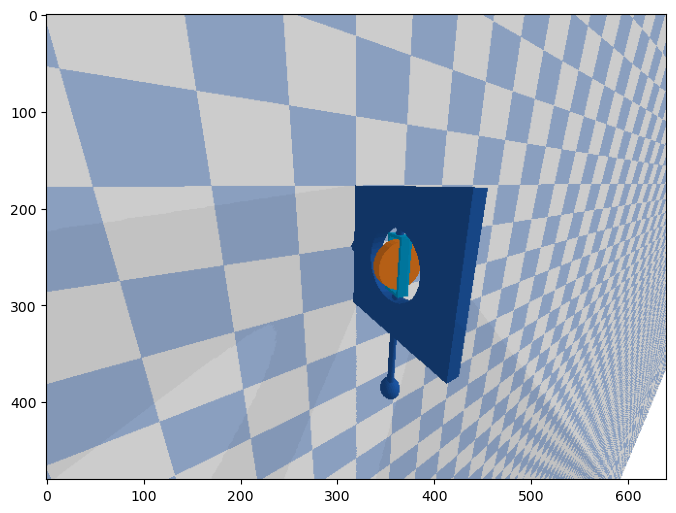

In [16]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

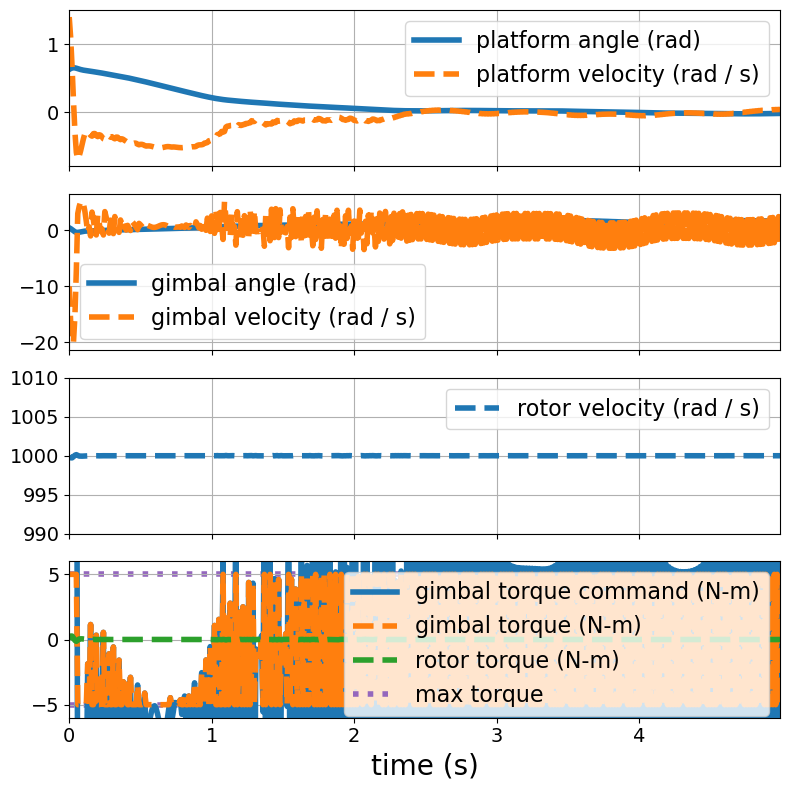

In [17]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_platform, ax_gimbal, ax_rotor, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot platform angle and velocity
ax_platform.plot(
    data['t'], data['platform_angle'],
    label='platform angle (rad)', linewidth=4,
)
ax_platform.plot(
    data['t'], data['platform_velocity'],
    '--', label='platform velocity (rad / s)', linewidth=4,
)
ax_platform.grid()
ax_platform.legend(fontsize=16)
ax_platform.tick_params(labelsize=14)

# Plot gimbal angle and velocity
ax_gimbal.plot(
    data['t'], data['gimbal_angle'],
    label='gimbal angle (rad)', linewidth=4,
)
ax_gimbal.plot(
    data['t'], data['gimbal_velocity'],
    '--', label='gimbal velocity (rad / s)', linewidth=4,
)
ax_gimbal.grid()
ax_gimbal.legend(fontsize=16)
ax_gimbal.tick_params(labelsize=14)

# Plot rotor velocity
ax_rotor.plot(
    data['t'], data['rotor_velocity'],
    '--', label='rotor velocity (rad / s)', linewidth=4,
)
ax_rotor.grid()
ax_rotor.legend(fontsize=16)
ax_rotor.tick_params(labelsize=14)
ax_rotor.set_ylim(simulator.rotor_velocity - 10., simulator.rotor_velocity + 10.)

# Plot torques
ax_torque.plot(
    data['t'], data['gimbal_torque_command'],
    label='gimbal torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['gimbal_torque'],
    '--', label='gimbal torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['rotor_torque'],
    '--', label='rotor torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', label='max torque', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

In [18]:
print((data['platform_angle'][-1]))

-0.02080432955959066


In [19]:

def get_data_simulation(simulator, q_1e, q_1de, q_2de, taue, K, q_1i, q_2i, v_1i, v_2i, max_time = 10.):
    controller = Controller( K, q_1e, q_2e, q_1de, q_2de, taue)
    
    simulator.reset(
    platform_angle= q_1i,
    platform_velocity= v_1i,
    gimbal_angle= q_2i,
    gimbal_velocity= v_2i,
    rotor_velocity=1000.,
    )
    
    controller.reset()
    
    data = simulator.run(
        controller,
        max_time = max_time,
    )
    return data


(50,)


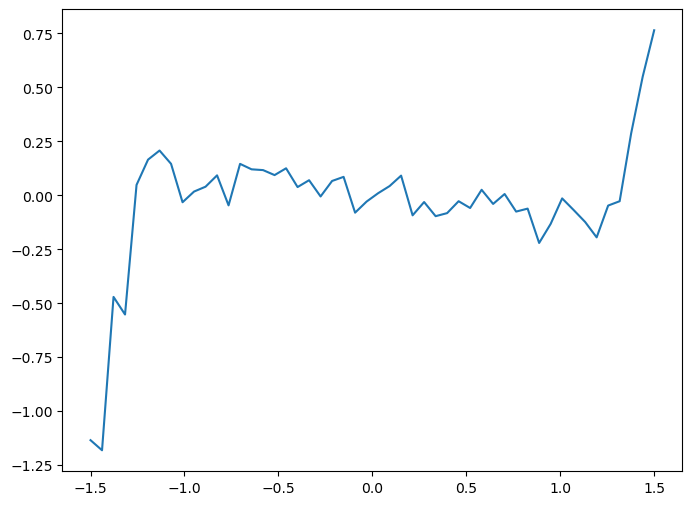

In [20]:
#Initial Platform angle array
q_1i = np.linspace(q_1e - 1.5, q_1e + 1.5, 50 )
(q_1i, q_2i, v_1i, v_2i) = (q_1i ,np.pi/7., 1.4, -10.)
q_1f = np.empty_like(q_1i)
print(q_1i.shape)
for i in range(len(q_1i)):
    data = get_data_simulation(simulator, q_1e, q_1de, q_2de, taue, K, q_1i[i], q_2i, v_1i, v_2i, max_time = 5.)
    q_1f[i] = data['platform_angle'][-1]

fig, (ax) = plt.subplots(1, 1, figsize = (8,6), sharex = True)
    
ax.plot(q_1i, q_1f, '-', markersize = 12, label = '$q_1(10)$')
    

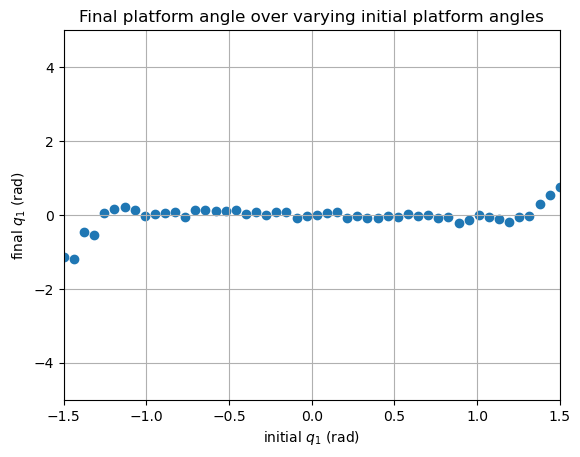

In [21]:
plt.scatter(q_1i, q_1f)
plt.xlim(q_1i[0], q_1i[-1])
plt.ylim(-5, 5)
plt.xlabel('initial $q_1$ (rad)')
plt.ylabel('final $q_1$ (rad)')
plt.title('Final platform angle over varying initial platform angles')
plt.grid()

In [22]:
#Initial Gimbal angle array
q_2i = np.linspace(q_2e - 3.14, q_2e + 0.5, 50)
(q_1i, q_2i, v_1i, v_2i) = (np.pi/5 ,q_2i, 1.4, -10.)
q_1f = np.empty_like(q_2i)

for i in range(len(q_2i)):
    data = get_data_simulation(simulator, q_1e, q_1de, q_2de, taue, K, q_1i, q_2i[i], v_1i, v_2i, max_time = 5.)
    q_1f[i] = data['platform_angle'][-1]



TypeError: 'float' object is not subscriptable

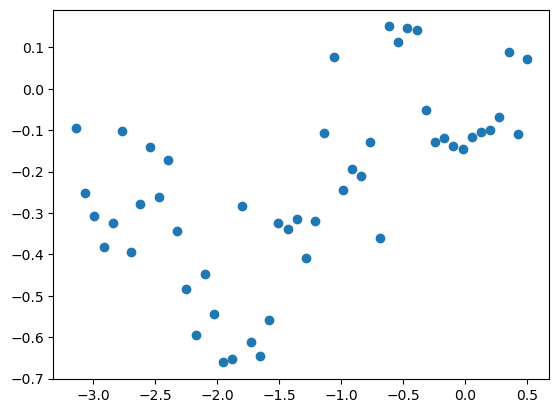

In [23]:
plt.scatter(q_2i, q_1f)
plt.xlim(q_2i[0], q_1i[-1])
plt.ylim(-5, 5)
plt.xlabel('initial $q_2$ (rad)')
plt.ylabel('final $q_1$ (rad)')
plt.title('Final platform angle over varying initial gimbal angles')

In [ ]:
#Initial Platform velocity array
v_1i = np.linspace(q_1de - 3, q_1de + 3, 50)
(q_1i, q_2i, v_1i, v_2i) = (np.pi/5 ,np.pi/7, v_1i, -10.)
q_1f = np.empty_like(v_1i)

for i in range(len(v_1i)):
    data = get_data_simulation(simulator, q_1e, q_1de, q_2de, taue, K, q_1i, q_2i, v_1i[i], v_2i, max_time = 5.)
    q_1f[i] = data['platform_angle'][-1]



In [ ]:
plt.scatter(v_1i, q_1f)
plt.xlim(v_1i[0], v_1i[-1])
plt.ylim(-5, 5)
plt.xlabel('initial $v_1$ (rad)')
plt.ylabel('final $q_1$ (rad)')
plt.title('Final platform angle over varying initial platform velocity')

In [ ]:
#Initial Platform velocity array
v_1i = np.linspace(q_2de - 100, q_2de + 100, 50)
(q_1i, q_2i, v_1i, v_2i) = (np.pi/5 ,np.pi/7, v_1i, -10.)
q_1f = np.empty_like(v_2i)

for i in range(len(v_2i)):
    data = get_data_simulation(simulator, q_1e, q_1de, q_2de, taue, K, q_1i, q_2i, v_1i, v_2i[i], max_time = 5.)
    q_1f[i] = data['platform_angle'][-1]

In [ ]:
plt.scatter(v_2i, q_1f)
plt.xlim(v_2i[0], v_2i[-1])
plt.ylim(-5, 5)
plt.xlabel('initial $v_2$ (rad)')
plt.ylabel('final $q_1$ (rad)')
plt.title('Final platform angle over varying initial platform velocity')